# **Irene Dovichi** 
## Midterm 2 - Assignment 3
Implement from scratch an RBM and apply it to DSET3. The RBM should be implemented fully by you (both CD-1 training and inference steps) but you are free to use library functions for the rest (e.g. image loading and management, etc.).

1. Train an RBM with a number of hidden neurons selected by you (single layer) on the MNIST data (use the training set split provided by the website).

2. Use the trained RBM to encode a selection of test images (e.g. using one per digit type) using the corresponding activation of the hidden neurons.

3. Train a simple classifier (e.g. any simple classifier in scikit) to recognize the MNIST digits using as inputs their encoding obtained at step 2. Use the standard training/test split. Show a performance metric of your choice in the presentation/handout.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import idx2numpy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.metrics import structural_similarity

## Dataset Loading

In [2]:
dataset_folder = 'mnist_db/'

# Load train and test images
train_images = idx2numpy.convert_from_file(os.path.join(dataset_folder, 'train-images-idx3-ubyte'))
test_images = idx2numpy.convert_from_file(os.path.join(dataset_folder, 't10k-images-idx3-ubyte'))

# Load train and test labels
train_labels = idx2numpy.convert_from_file(os.path.join(dataset_folder, 'train-labels-idx1-ubyte'))
test_labels = idx2numpy.convert_from_file(os.path.join(dataset_folder, 't10k-labels-idx1-ubyte'))

Image shape: (28, 28)
Pixel value range: 0 - 255
Label: 5


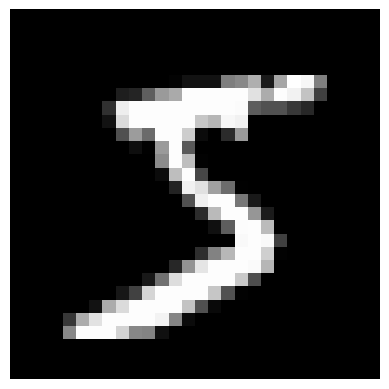

In [3]:
# Print the first image in the train set
first_image = train_images[0]
first_label = train_labels[0]

# Print the shape of the image
print("Image shape:", first_image.shape)

# Print the ranges of pixel values
print("Pixel value range:", first_image.min(), "-", first_image.max())

# Print the label of the image
print("Label:", first_label)

plt.imshow(first_image.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()


### Data Preprocessing

In [4]:
# Normalize pixel values
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Binarize the images
threshold = 0.5
train_images_b = np.where(train_images > threshold, 1, 0)
test_images_b = np.where(test_images > threshold, 1, 0)

# Reshape to 1D array
train_images_b = train_images_b.reshape(-1, 28*28)
test_images_b = test_images_b.reshape(-1, 28*28)

Image shape: (784,)
Pixel value range: 0 - 1


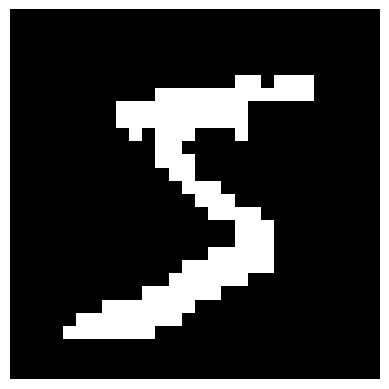

In [5]:
# See the change in the first image of the train set
first_image = train_images_b[0]

# Print the shape of the image
print("Image shape:", first_image.shape)

# Print the ranges of pixel values
print("Pixel value range:", first_image.min(), "-", first_image.max())

plt.imshow(first_image.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

## RBM Implementation 

I implemented the class `RBM` from scratch in the next cell; some relevant choices are as follows:
- I initialized the weights with a Gaussian distribution of mean 0 and standard deviation 0.01
- I initialized the biases of visible units considering the proportion of training data in which they are on, i.e., for each unit $i = 1, \dots, n_{visible}$ the initial weight was: $$log\bigl(\frac{p_i + \varepsilon}{1 - p_i + \varepsilon}\bigr)$$ where $p_i$ is the average number of train images that have pixel $i$ turned on, and $\varepsilon=$ 1e-5 was added to avoid problems in case of a zero denominator
- I initialized the biases of hidden units to zero
- sampling for hidden states !!!!!!!!!!!!!!!!!!!!!!!!!!!!
- no sampling for reconstructed states !!!!!!!!!!!!!!!!!!!!!!!!!!!!
- I implemented a `train()` method which is CD-1 in the mini-batch version
- `reconstruct()` !!!!!!!!!!!!!!!!!!!!!!!!!!!!
- `encoding()` !!!!!!!!!!!!!!!!!!!!!!!!!!!!

These choices were made based mainly on the paper: 'Geoffrey Hinton, [A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/%7Ehinton/absps/guideTR.pdf), Technical Report 2010-003, University of Toronto, 2010'.

In [6]:
class RBM:
    def __init__(self, visible_units, hidden_units, train_images):
        self.v = visible_units
        self.h = hidden_units
        self.train_images = train_images
        # Initialize weights to small random values taken from 0 mean gaussian with standard deviation 0.01
        self.W = np.random.randn(self.h, self.v) * 0.01
        # Initialize biases of visible units to log(p_i/(1-p_i)) where p_i is the proportion of training data where unit i is on
        self.bv = np.log((np.mean(self.train_images, axis=0) + 1e-5) / (1 - np.mean(self.train_images, axis=0) + 1e-5))
        # Initialize biases of hidden units to zero
        self.bh = np.zeros(self.h)
        self.epoch_errors = np.array([])
        self.errors = np.array([])

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def train(self, dataset, learning_rate, epochs, batch_size): 
        num_batches = len(dataset) // batch_size
        remainder = len(dataset) % batch_size

        for epoch in tqdm(range(epochs)):
            self.epoch_errors = []
            for i in range(num_batches):
                batch = dataset[i * batch_size : (i + 1) * batch_size]

                ## Compute wake part
                hidden_prob = self.sigmoid(np.dot(batch, self.W.T) + self.bh)
                wake = np.dot(hidden_prob.T, batch)

                ## Compute dream part
                # When the hidden units are being driven by the data, always use stochastic binary states
                hidden_states = np.random.rand(batch_size, self.h) < hidden_prob
                recon_prob = self.sigmoid(np.dot(hidden_states, self.W) + self.bv)
                # When they are being driven by reconstructions, always use probabilities without sampling
                recon_states = recon_prob
                hidden_prob_rec = self.sigmoid(np.dot(recon_states, self.W.T) + self.bh)
                dream = np.dot(hidden_prob_rec.T, recon_states)

                ## CD-1 update
                self.W += learning_rate * (wake - dream) / batch_size
                self.bv += learning_rate * np.mean(batch - recon_states, axis=0)
                self.bh += learning_rate * np.mean(hidden_prob - hidden_prob_rec, axis=0)

                ## Reconstruction error: MSE
                epoch_error = np.mean((batch - recon_states) ** 2)
                self.epoch_errors.append(epoch_error)

            if remainder > 0:
                batch = dataset[num_batches * batch_size :]

                ## Compute wake part
                hidden_prob = self.sigmoid(np.dot(batch, self.W.T) + self.bh)
                wake = np.dot(hidden_prob.T, batch)

                ## Compute dream part
                hidden_states = np.random.rand(remainder, self.h) < hidden_prob
                recon_prob = self.sigmoid(np.dot(hidden_states, self.W) + self.bv)
                recon_states = recon_prob
                hidden_prob_rec = self.sigmoid(np.dot(recon_states, self.W.T) + self.bh)
                dream = np.dot(hidden_prob_rec.T, recon_states)

                ## CD-1 update
                self.W += learning_rate * (wake - dream) / remainder
                self.bv += learning_rate * np.mean(batch - recon_states, axis=0)
                self.bh += learning_rate * np.mean(hidden_prob - hidden_prob_rec, axis=0)

                ## Reconstruction error: MSE
                remainder_error = np.mean((batch - recon_states) ** 2)
                self.epoch_errors.append(remainder_error)
            
            self.errors = np.append(self.errors, np.mean(self.epoch_errors))

    def reconstruct(self, data):
        hidden_prob = self.sigmoid(np.dot(data, self.W.T) + self.bh)
        recon_prob = self.sigmoid(np.dot(hidden_prob, self.W) + self.bv)
        return recon_prob
    
    def encoding(self, data):
        hidden_prob = self.sigmoid(np.dot(data, self.W.T) + self.bh)
        return hidden_prob

## RBM Training Phase

In [ ]:
#TODO: provare senza binarizzazione (usare train_images e test_images al posto di train/test_images_b --> fare il reshape a 1D vector)
#TODO: plottare i weights
#TODO: usare altre metriche tipo ssim (o altro) per dire quanto bene l'immagine è stata ricostruita: usare in DIGITS
#TODO: gaussian noise
#TODO: histogram showing the hardest digits to reconstruct

Let's do a first try with RBM class to see if it is working

the number of `visible_units` is 784 since it is the length of the flattened MNIST images

In [7]:
rbm = RBM(visible_units=784, hidden_units=512, train_images=train_images_b)
rbm.train(dataset=train_images_b, learning_rate=0.5, epochs=50, batch_size=100)

100%|██████████| 50/50 [04:07<00:00,  4.94s/it]


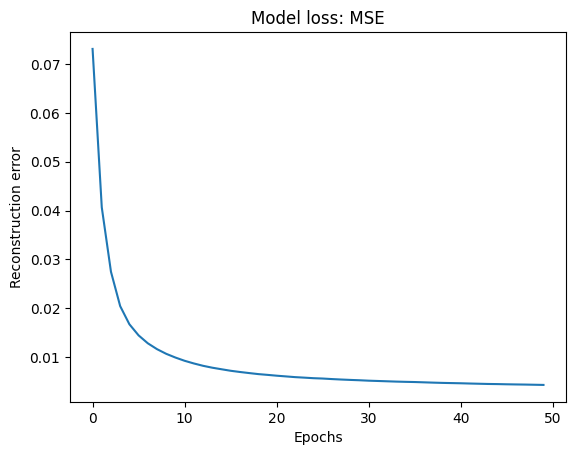

In [8]:
# plot the errors
plt.plot(rbm.errors)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.title('Model loss: MSE')
plt.show()

In [9]:
print('Final error:', rbm.errors[-1])

Final error: 0.00429628268646193


## Encoding and Reconstruction 

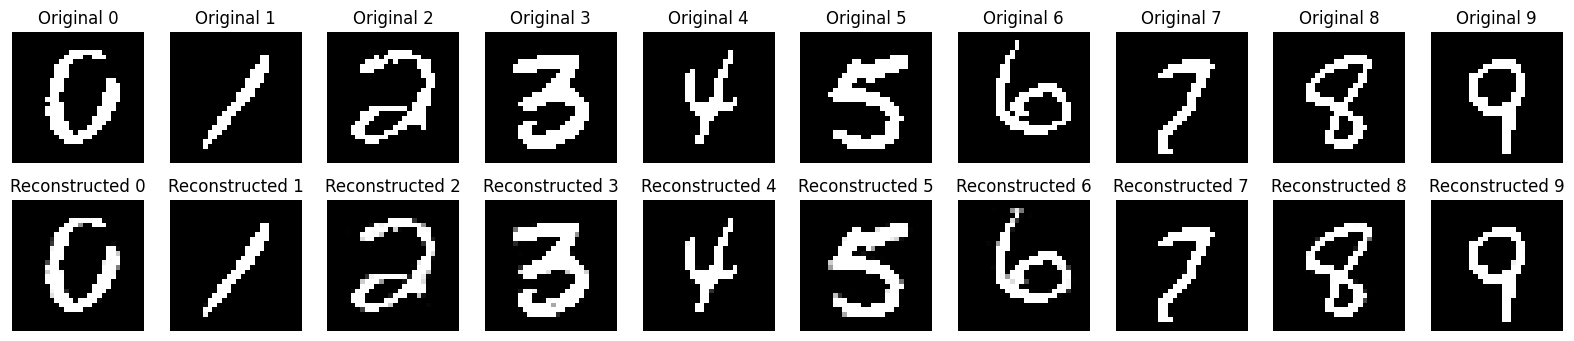

In [10]:
# take an image from the test set for each digit
digits = []
for i in range(10):
    index = np.random.randint(0, len(test_images_b[test_labels == i]))
    digits.append(test_images_b[test_labels == i][index])

# reconstruct the images
reconstructed_digits = []
for digit in digits:
    reconstructed_digits.append(rbm.reconstruct(digit))

# plot the original and reconstructed images: first row original, second row reconstructed
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(digits[i].reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title('Original ' + str(i))
    axs[1, i].imshow(reconstructed_digits[i].reshape(28, 28), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title('Reconstructed ' + str(i))

Let's compare the reconstructed images with the original ones of the (binarized) test set using SSIM metric.

In [22]:
def ssim(rbm, data):
    recon = rbm.reconstruct(data)
    return np.mean([structural_similarity(data[i], recon[i], data_range=1) for i in range(len(data))])

In [23]:
ssim_scores = []

# Compute the SSIM score for each digit in the test set
for i in range(10):
    ssim_scores.append(ssim(rbm, test_images_b[test_labels == i]))

# Print the ssim scores of each digit
for i in range(10):
    print(f'Digit {i}: {ssim_scores[i]}')

Digit 0: 0.9797840230660538
Digit 1: 0.9988705366106968
Digit 2: 0.9741708515505353
Digit 3: 0.981339614050449
Digit 4: 0.9878162580902254
Digit 5: 0.9817908758824734
Digit 6: 0.9832744612370812
Digit 7: 0.9898396678636501
Digit 8: 0.9821788043275529
Digit 9: 0.9922361160334986


## Classification Phase

Let's start by identifying a MLP model that gives satisfying results on the MNIST dataset

Accuracy: 0.9699


/Users/irene/VSCodeProjects/ISPR/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


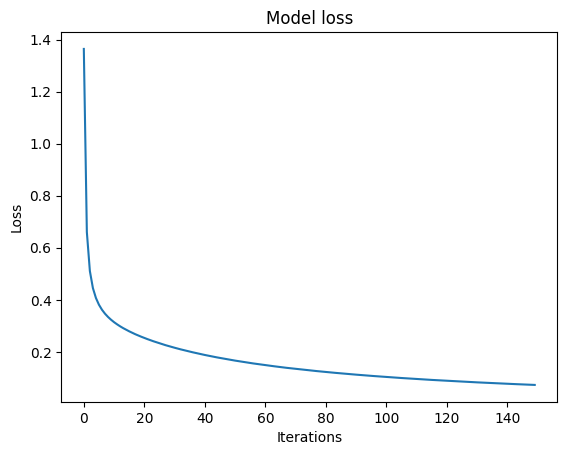

In [25]:
model = MLPClassifier(
    hidden_layer_sizes=(512,), 
    max_iter=150, 
    alpha=1e-4,
    solver='sgd'
)
model.fit(train_images_b, train_labels)

predictions = model.predict(test_images_b)
accuracy = accuracy_score(test_labels, predictions)

print('Accuracy:', accuracy)

# plot the loss
plt.plot(model.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Model loss')
plt.show()

In [27]:
print('Classification report: \n', classification_report(test_labels, predictions))

Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.97      0.97       892
           6       0.97      0.97      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



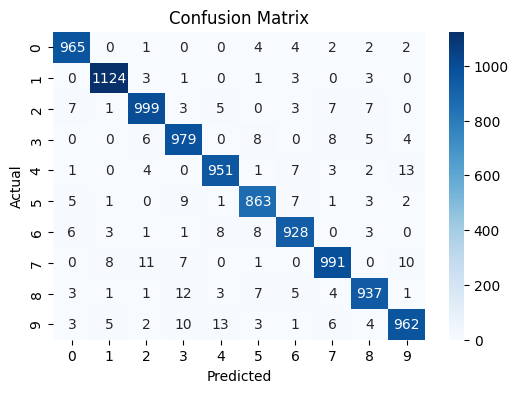

In [28]:
# plot the confusion matrix
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Now, let's prepare the econding relative to the train and test set using the method `encoding()` of the class `RBM` implemented above in the notebook. Then, train the same MLP of the cell above and compare the results.

In [29]:
train_images_encodings = rbm.encoding(train_images_b)
test_images_encodings = rbm.encoding(test_images_b)

Accuracy: 0.9646


/Users/irene/VSCodeProjects/ISPR/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


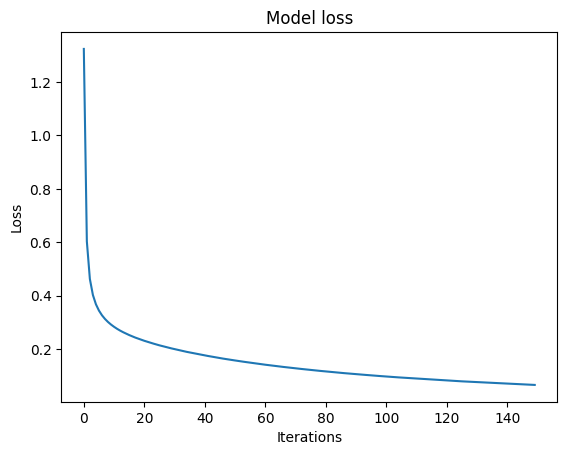

In [30]:
model.fit(train_images_encodings, train_labels)

predictions = model.predict(test_images_encodings)
accuracy = accuracy_score(test_labels, predictions)

print('Accuracy:', accuracy)

# plot the loss
plt.plot(model.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Model loss')
plt.show()

In [31]:
print('Classification report: \n', classification_report(test_labels, predictions))

Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.96      0.95      0.95       892
           6       0.97      0.98      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.93      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



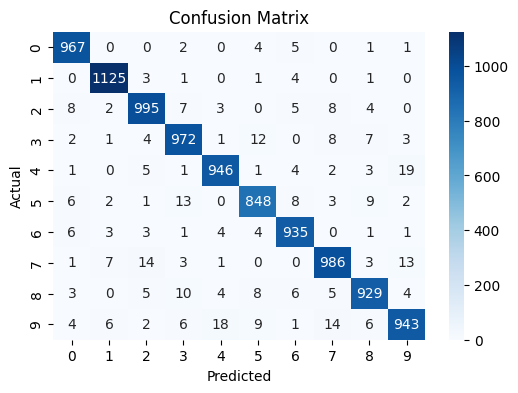

In [32]:
# plot the confusion matrix
cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [33]:
#TODO: commenti

## Personal Considerations

In [34]:
#TODO: considerazioni sulle rbm provate, alla fine ho lasciato 50 di minibatch (vero????) che rispetto a 100......